# Importing modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

from matplotlib import pyplot as plt
import lightgbm as lgb
import lightgbm as lgb
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
sns.set()

## Uploading data


In [3]:
data = pd.read_csv('train.csv', sep = ',')

Checking random lines

In [4]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2047,53,54.90,3045.75,Male,0,No,No,No,No phone service,DSL,No,No,Yes,Yes,Yes,Yes,One year,No,Credit card (automatic),0
389,5,63.95,318.1,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,Yes,No,Month-to-month,Yes,Credit card (automatic),0
1872,21,60.25,1258.35,Female,0,No,No,Yes,No,DSL,Yes,No,Yes,Yes,No,No,One year,Yes,Electronic check,0
2137,52,105.05,5624.85,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
2623,51,79.60,3974.7,Male,1,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,One year,Yes,Bank transfer (automatic),0


Checking data shape

In [5]:
data.shape

(5282, 20)

Checking data types

In [6]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

Getting feature and target columns

In [7]:
target_column = 'Churn'
feature_columns = data.drop(target_column, axis=1).columns
numeric_columns = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']

In [8]:
data[feature_columns].apply(lambda x: x.unique())

ClientPeriod                [55, 72, 1, 32, 60, 25, 27, 50, 16, 70, 69, 26...
MonthlySpending             [19.5, 25.85, 75.9, 79.3, 115.25, 19.8, 90.15,...
TotalSpent                  [1026.35, 1872.2, 75.9, 2570, 6758.45, 475.2, ...
Sex                                                            [Male, Female]
IsSeniorCitizen                                                        [0, 1]
HasPartner                                                          [Yes, No]
HasChild                                                            [Yes, No]
HasPhoneService                                                     [Yes, No]
HasMultiplePhoneNumbers                           [No, Yes, No phone service]
HasInternetService                                     [No, Fiber optic, DSL]
HasOnlineSecurityService                       [No internet service, No, Yes]
HasOnlineBackup                                [No internet service, No, Yes]
HasDeviceProtection                            [No internet serv

Removing data for clients with no client period

In [9]:
data = data[data['ClientPeriod'] != 0]

Fixing data type

In [10]:
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])

Checking NAs

In [11]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

# Data Preparation

Encoding categorical columns

In [12]:
categorical_columns = [column for column in feature_columns if column not in numeric_columns]

In [13]:
data[feature_columns].nunique()

ClientPeriod                  72
MonthlySpending             1466
TotalSpent                  4977
Sex                            2
IsSeniorCitizen                2
HasPartner                     2
HasChild                       2
HasPhoneService                2
HasMultiplePhoneNumbers        3
HasInternetService             3
HasOnlineSecurityService       3
HasOnlineBackup                3
HasDeviceProtection            3
HasTechSupportAccess           3
HasOnlineTV                    3
HasMovieSubscription           3
HasContractPhone               3
IsBillingPaperless             2
PaymentMethod                  4
dtype: int64

In [14]:
dummies = pd.get_dummies(data[categorical_columns])



# Data Analysis


In [20]:
eda = data.copy()

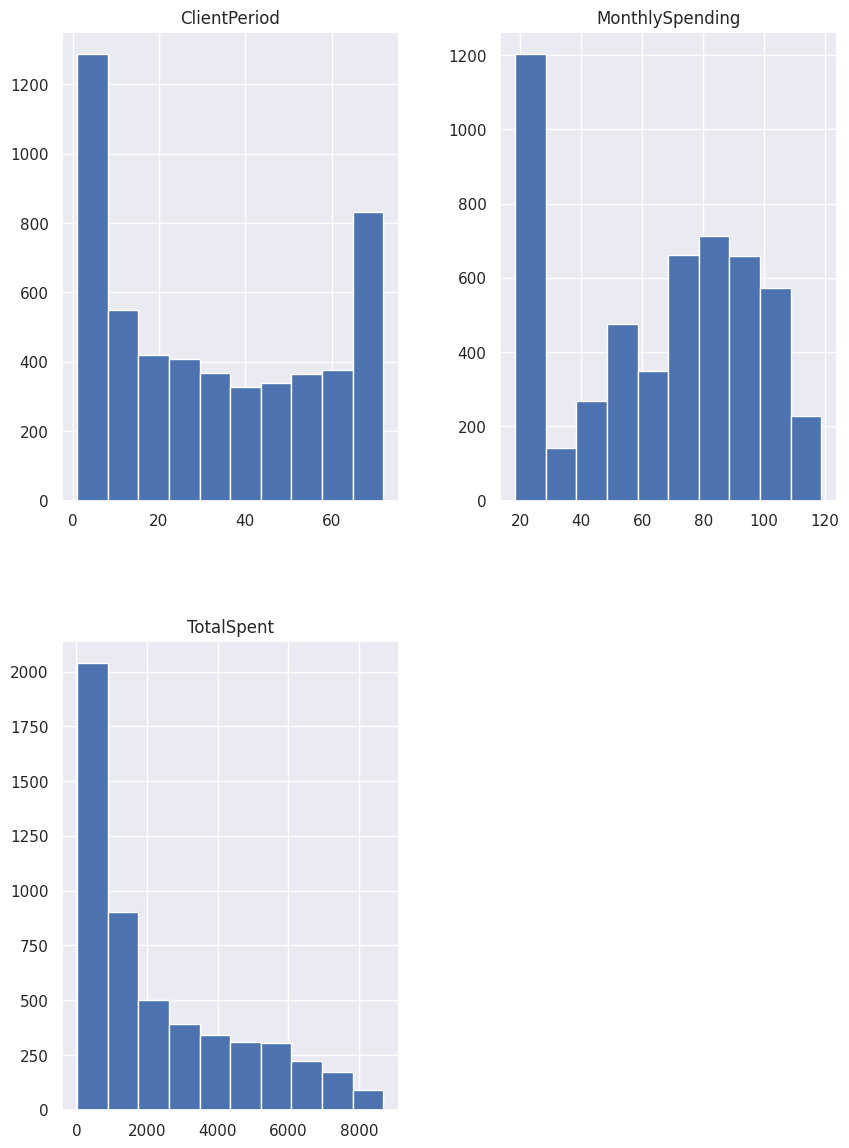

In [21]:
#building histograms for numerical features
eda.hist(column=numeric_columns, figsize=(10, 14));


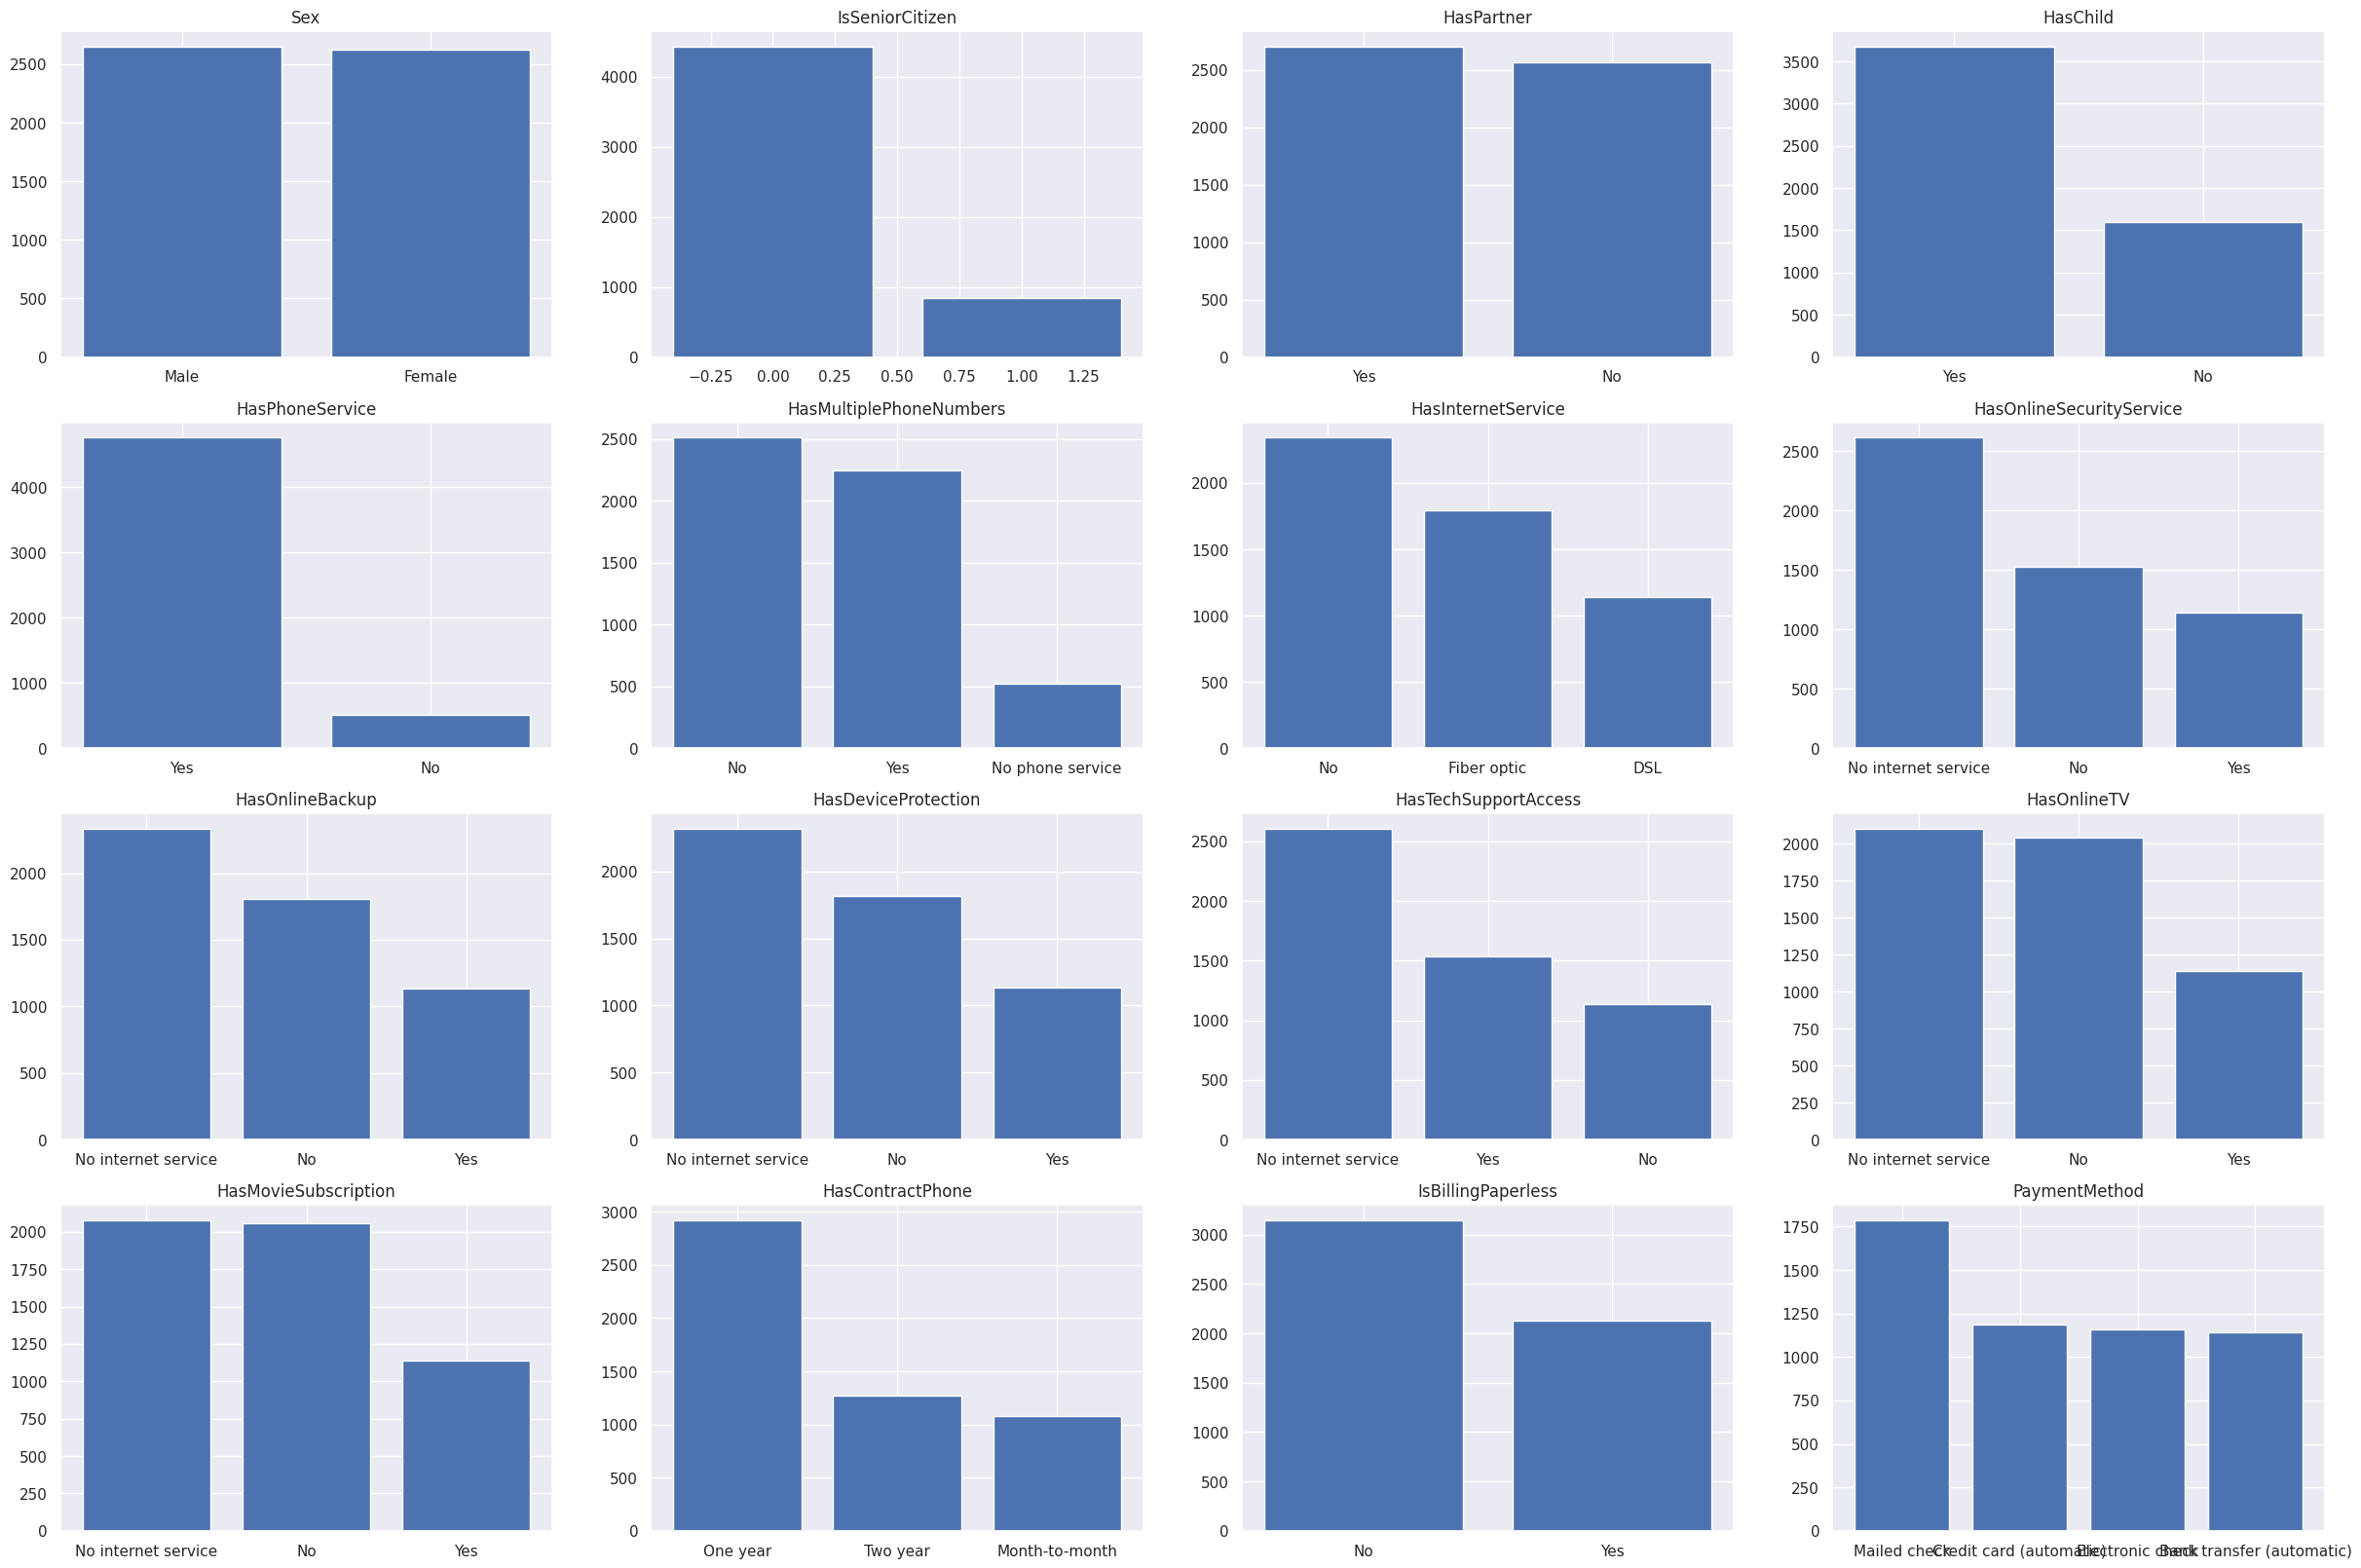

In [22]:
f = plt.figure(figsize = (30, 20))

i = 1
for col in categorical_columns:
    plt.subplot(4, 4, i)
    plt.bar(eda[col].unique(), eda[col].value_counts())
    plt.title(col)
    i += 1

Checking how target column is distributed and if there's
class imbalance

0    0.737531
1    0.262469
Name: Churn, dtype: float64

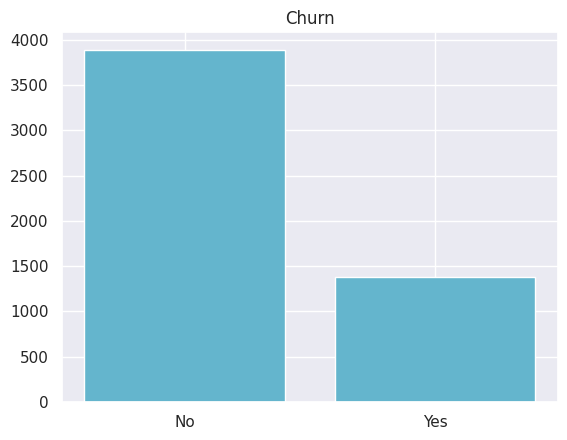

In [23]:
plt.bar(['No', "Yes"], eda['Churn'].value_counts(), color = 'c')
plt.title("Churn")
eda['Churn'].value_counts() / len(eda)


Checking if there's correlation between numerical features

In [24]:
eda[numeric_columns].corr().style.background_gradient(cmap='coolwarm').set_precision(2)


<ipython-input-24-81be03257df4>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  eda[numeric_columns].corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,ClientPeriod,MonthlySpending,TotalSpent
ClientPeriod,1.00,0.25,0.83
MonthlySpending,0.25,1.00,0.65
TotalSpent,0.83,0.65,1.00


TotalSpent correlates with ClientPeriod and MonthlySpending

Let's try to predict TotalSpent with MonthlySpending * ClientPeriod

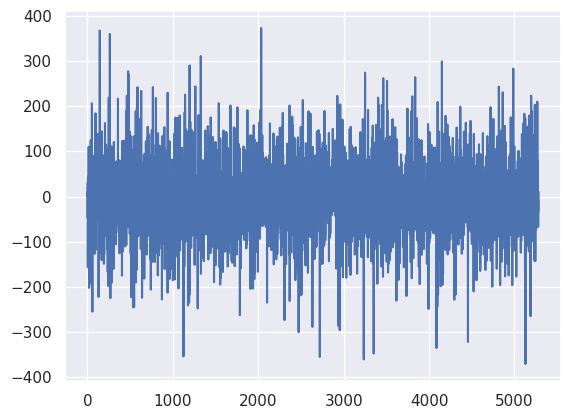

In [25]:
y1 = eda['MonthlySpending'] * eda['ClientPeriod']
y2 = eda['TotalSpent']
d = y2 - y1
plt.plot((d))


Creating new variable which shows difference between real and predicted spending


In [26]:
newcol = pd.Series(eda['TotalSpent'] - eda['ClientPeriod'] * eda['MonthlySpending'])

In [27]:
eda['Difference'] = newcol

Checking how well a target variable can be broken by the new variable Difference



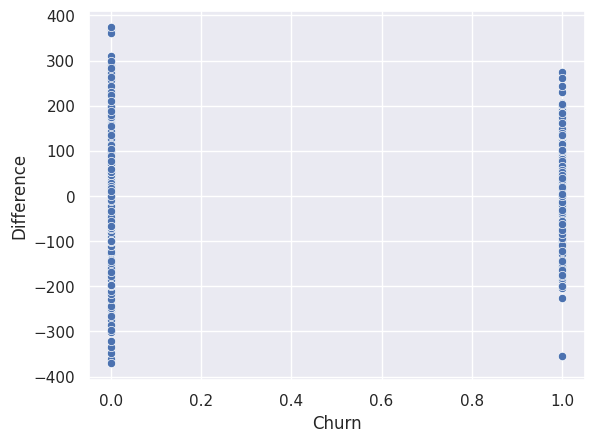

In [28]:
sns.scatterplot(y=eda['Difference'], x=eda['Churn']);

Removing the new column

In [29]:
eda = eda.drop(['Difference'], axis = 1)

Seeing how target variable is distributed with each pair of numerical features


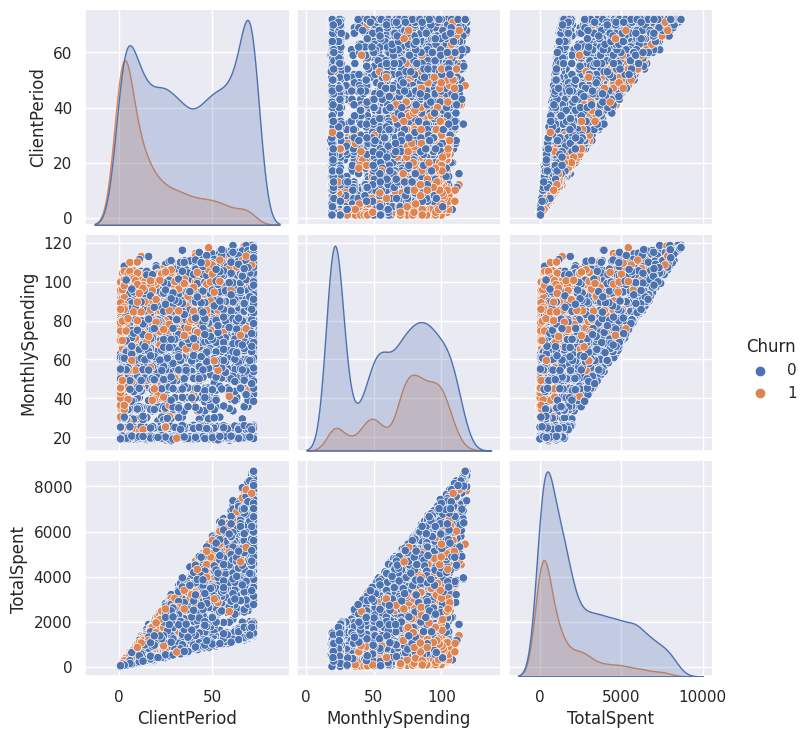

In [30]:
sns.pairplot(data = pd.concat([eda[numeric_columns], eda['Churn']], axis = 1), hue = 'Churn')

It can be seen that Churn cannot be easily separated using a pair of feature variables.

Let's look at the distribution of target variable across
feature variables

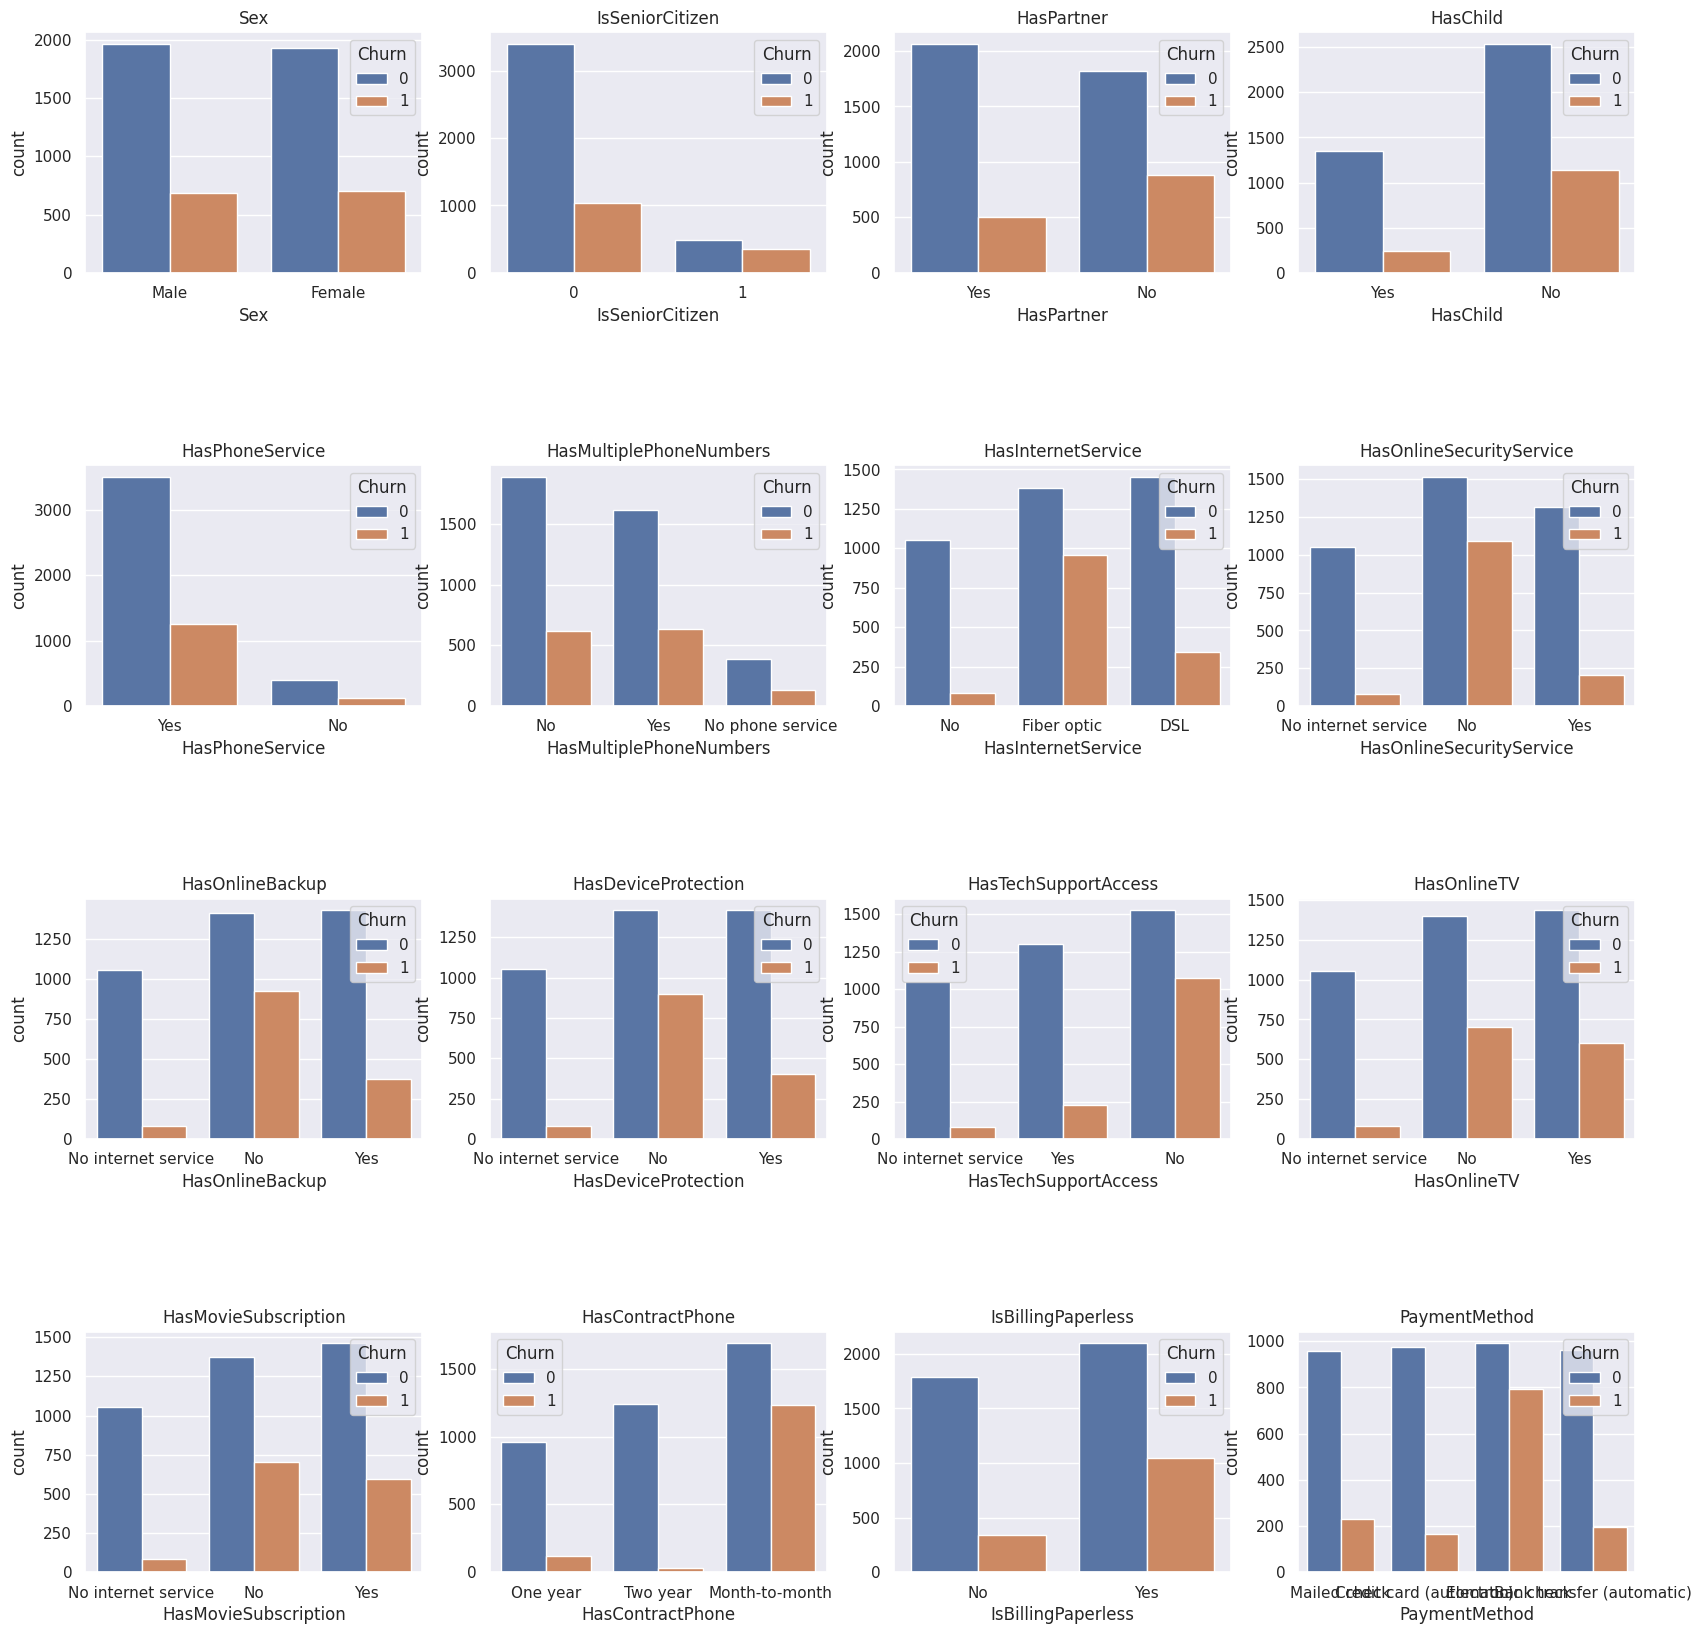

In [31]:
fig = plt.figure(figsize = (20, 20))
i = 1
for col in categorical_columns:
    plt.subplot(4, 4, i)
    sns.countplot(x = col, data = eda,  hue = 'Churn')
    plt.title(col)
    plt.subplots_adjust(hspace = 0.8)
    i += 1


# Data Preparation

Data Split on train and test samples

In [32]:
new_dummies = dummies.copy()

Selecting features choosing those that correlate with the target
variable

In [33]:
selected_dummies=  ['IsSeniorCitizen',  'HasPartner_Yes',
 'HasChild_Yes',
'HasInternetService_Fiber optic', 'HasInternetService_No',
 'HasOnlineSecurityService_No', 'HasOnlineSecurityService_Yes',
'HasOnlineBackup_No', 'HasOnlineBackup_Yes', 'HasDeviceProtection_No',
'HasDeviceProtection_Yes', 'HasContractPhone_Month-to-month',
'HasContractPhone_Two year',
'IsBillingPaperless_No',
'HasTechSupportAccess_No',
'HasMovieSubscription_No',
'PaymentMethod_Electronic check'
  ]

In [34]:
df = pd.concat([data[numeric_columns], new_dummies[selected_dummies], data['Churn']], axis = 1)

In [35]:
train_features, test_features, train_labels, test_labels = train_test_split(
    df.drop('Churn', axis=1), df['Churn'], train_size=0.8
)

Let's remove TotalSpent as it correlates with ClientPeriod

In [36]:
numeric_columns = ['ClientPeriod', 'MonthlySpending']

## Feature Scaling

In [37]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(train_features[numeric_columns])
X_test_scaled = scaler.transform(test_features[numeric_columns])
X_train_scaled = pd.concat([pd.DataFrame(X_train_scaled, index = train_features.index), train_features[selected_dummies]], axis = 1).to_numpy()#X_test_scaled = pd.concat([pd.DataFrame(X_test_scaled), test_features[selected_dummies].reset_index()], axis = 1).to_numpy()
X_test_scaled = pd.concat([pd.DataFrame(X_test_scaled, index = test_features.index), test_features[selected_dummies]], axis = 1).to_numpy()


# Data Modeling

## Baseline Model



Running logistic regression as the baseline model

In [38]:
logr = LogisticRegression()
logr.fit(X_train_scaled, train_labels)
pred = logr.predict_proba(X_test_scaled)

from sklearn.metrics import roc_auc_score, roc_curve
y_train_predicted = logr.predict_proba(X_train_scaled)[:, 1]
y_test_predicted = logr.predict_proba(X_test_scaled)[:, 1]
train_auc = roc_auc_score(train_labels, y_train_predicted)
test_auc = roc_auc_score(test_labels, y_test_predicted)
print(train_auc, test_auc)

0.8441786232889953 0.8437372981561542


In [39]:
print(classification_report(logr.predict(X_test_scaled), test_labels))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       839
           1       0.51      0.66      0.57       216

    accuracy                           0.80      1055
   macro avg       0.71      0.75      0.72      1055
weighted avg       0.82      0.80      0.81      1055



Searching for best parameters

In [40]:
#solvers
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# model
clf = LogisticRegression(max_iter = 10000, solver = 'saga')

# parameters for gridsearch
param_grid = {
    'C': [100, 10, 1, 1.2, 1.5,  0.1, 0.001, 0.01, 0.005], 'penalty' : ['l1', 'l2']

}

# object GridSearchCV
search = GridSearchCV(clf, param_grid, refit = True, cv = 5, scoring= 'roc_auc')


search.fit(X_train_scaled, train_labels)

# printing best parameters
print(search.best_params_)

{'C': 0.1, 'penalty': 'l2'}


In [43]:
search.best_params_['penalty']

'l2'

In [44]:
#running logistic regression with best parameters
logr = LogisticRegression(C = search.best_params_['C'], penalty =
  search.best_params_['penalty'], solver = 'saga', max_iter = 10000)
logr.fit(X_train_scaled, train_labels)
pred = logr.predict_proba(X_test_scaled)

from sklearn.metrics import roc_auc_score, roc_curve
y_train_predicted = logr.predict_proba(X_train_scaled)[:, 1]
y_test_predicted = logr.predict_proba(X_test_scaled)[:, 1]
train_auc = roc_auc_score(train_labels, y_train_predicted)
test_auc = roc_auc_score(test_labels, y_test_predicted)
print(train_auc, test_auc)

0.8440233846386413 0.8442084210915273


In [45]:
print(classification_report(logr.predict(X_test_scaled), test_labels))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       837
           1       0.52      0.66      0.58       218

    accuracy                           0.80      1055
   macro avg       0.71      0.75      0.72      1055
weighted avg       0.82      0.80      0.81      1055



## Gradient Boosting



Running LGBMClassifier

In [46]:
main_model = lgb.LGBMClassifier()

In [47]:
main_model.fit(
    X_train_scaled, train_labels,
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
    eval_set=(X_test_scaled, test_labels)
)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.416944


LGBMClassifier()

In [48]:
roc_auc_score(main_model.predict(X_train_scaled), train_labels)

0.8008082995668575

In [49]:
roc_auc_score(main_model.predict(X_test_scaled), test_labels)

0.743155687888216

In [50]:
print(classification_report(main_model.predict(X_test_scaled), test_labels))

              precision    recall  f1-score   support

           0       0.90      0.83      0.87       842
           1       0.50      0.65      0.57       213

    accuracy                           0.80      1055
   macro avg       0.70      0.74      0.72      1055
weighted avg       0.82      0.80      0.81      1055



Running xgboost

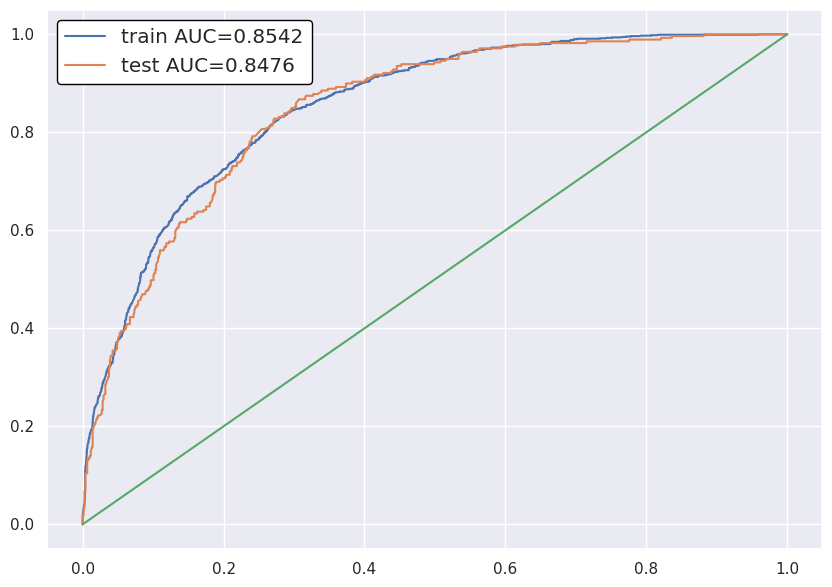

In [51]:
boosting_model = xgb.XGBClassifier(max_depth = 1, learning_rate = 0.4, n_estimators= 60)

boosting_model.fit(X_train_scaled, train_labels)

y_train_predicted = boosting_model.predict_proba(X_train_scaled)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_scaled)[:, 1]
train_auc = roc_auc_score(train_labels, y_train_predicted)
test_auc = roc_auc_score(test_labels, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(train_labels, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(test_labels, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [52]:
print(classification_report(boosting_model.predict(X_test_scaled), test_labels))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       832
           1       0.51      0.64      0.57       223

    accuracy                           0.80      1055
   macro avg       0.70      0.74      0.72      1055
weighted avg       0.82      0.80      0.80      1055




Best quality was achieved on logistic regression with the following parameters:
LogisticRegression(C = 0.1, penalty = 'l2', solver = 'saga', max_iter = 10000)

Neural Network

In [55]:
model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[19]),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [56]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [57]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train_scaled, train_labels,
    validation_data=(X_test_scaled, test_labels),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 0.4246
Best Validation Accuracy: 0.8095


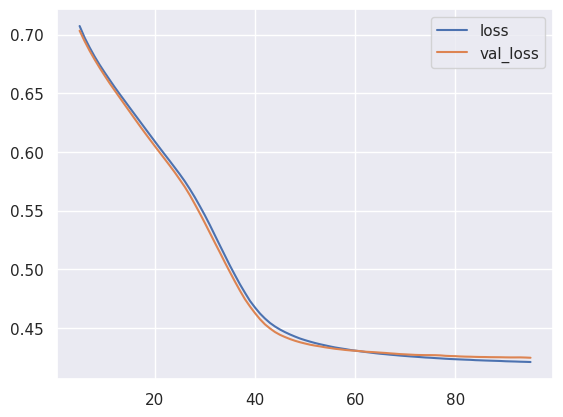

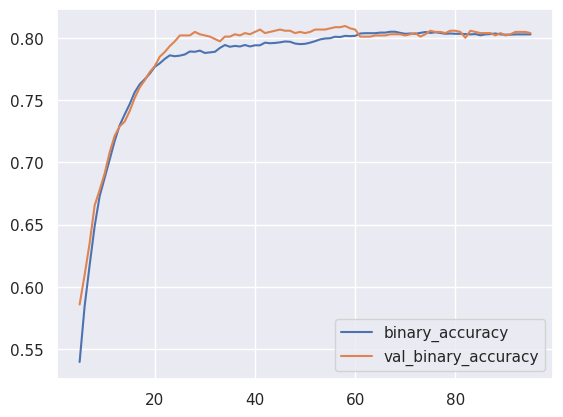

In [58]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_binary_accuracy'].max()))

Simple NN didn't show result better than logreg.